In [1]:
# Copyright [2025] [KTH Royal Institute of Technology] 
# Licensed under the Educational Community License, Version 2.0 (ECL-2.0)
# This file is part of the Computer Lab 1 for EL2805 - Reinforcement Learning.

# Load packages
import numpy as np
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import pickle

# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

In [24]:
class Model:

    def __init__(self, eta, lam, gamma, mu, weight_init="zeros"):
        self.eta = eta #(m,2)
        self.m = eta.shape[0]
        self.weights = self.__init_weights(self.m, weight_init) #(m,3)
        self.z = np.zeros((self.m,3))
        self.lam = lam
        self.gamma = gamma
        self.v = np.zeros((self.m,3))
        self.mu = mu

        eta_norm = np.linalg.norm(self.eta, axis=1)
        self.inv_eta_norm = np.diag(1/np.where(eta_norm > 0, eta_norm, 1)) # (m,m) diag
        

    def forward(self, s):
        return self.weights.T @ np.cos(np.pi*self.eta @ s) # (3,)

    def __init_weights(self, m, weight_init):
        if weight_init == "zeros":
            return np.zeros((m,3))
        elif weight_init == "gaussian":
            return  np.random.randn(m,3)
        elif weight_init == "ones":
            return np.ones((m,3))
        elif weight_init == "minus_ones":
            return -np.ones((m,3))
        else:
            raise Exception("Unknown weight init")
    
    def eps_greedy(self, s, eps):
        if np.random.rand() < 1-eps:
            return np.argmax(self.forward(s))
        else:
            return np.random.randint(3)

    def update_trace(self, s, a):
        self.z *= self.gamma*self.lam
        self.z[:, a] += np.cos(np.pi*self.eta @ s)
        self.z = np.clip(self.z, -5, 5)

    def Phi(self, s):
        return np.cos(np.pi*self.eta @ s)

    def Q(self,s,a):
        return (self.weights.T @ self.Phi(s))[a]

    def update_weights(self, s, a, r, s_next, a_next, alpha):
        delta = (r+self.gamma*self.Q(s_next, a_next)-self.Q(s,a))
        self.weights +=  alpha*delta*(self.inv_eta_norm @ self.z)

    def update_weights_momentum(self, s, a, r, s_next, a_next, alpha):
        delta = (r+self.gamma*self.Q(s_next, a_next)-self.Q(s,a))
        self.v = self.mu * self.v + alpha*delta*(self.inv_eta_norm @ self.z)
        self.weights += self.v
    
    def update_weights_nesterov(self, s, a, r, s_next, a_next, alpha):
        delta = (r+self.gamma*self.Q(s_next, a_next)-self.Q(s,a))
        self.v = self.mu * self.v + alpha*delta*(self.inv_eta_norm @ self.z)
        self.weights += self.mu * self.v + alpha*delta*(self.inv_eta_norm @ self.z)
    

    def reset_trace(self):
        self.z = np.zeros((self.m,3))
        self.v = np.zeros((self.m,3))

    def save(self, file_name):
        d = {}
        d["N"] = self.eta
        d["W"] = self.weights.T

        with open(file_name, 'wb') as file:
            pickle.dump(d, file)

In [3]:

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x


In [4]:
# ----- good combos
# np.array([[1,1], [2, 2], [1, 2], [2, 1], [0, 1]])
# -----

# np.array([[0,1], [0,2], [1, 0], [2, 0]])
# np.array([[0, 1], [0,0], [0, 2]])#random.np.array([(i,j) for i in range(3) for j in range(3)])
# np.array([(i,j) for i in range(3) for j in range(3)])
# np.array([[0, 1], [0, 2], [1, 1], [2,2]]) #np.array([(i,j) for i in range(3) for j in range(3)]) # (m,2)

eta = np.array([[1,1], [2, 2], [1, 2], [2, 1], [0, 1], [0,0]])
lam = 0.8 # for eligibility trace
gamma = 1.0 # discount factor
N_episodes = 200 # Number of episodes to run for training
EPS = 0.05 # base exploration rate
ALPHA = 0.003 # base learning rate

lr_lookback = 5 # learning rate reduction lookback
lr_threshold = -160 # threshold for learning rate reduction
# factor to multiply lr with if mean over last look_back episode rewards is less than lr_threshold:
lr_factor = 0.1

mu = 0.5 # SGD momentum/nesterov factor

In [5]:
params = {
    "eta": tuple(tuple(int(x) for x in row) for row in eta),
    "lam": lam,
    "gamma": gamma,
    "N_episodes": N_episodes,
    "EPS": EPS,
    "ALPHA": ALPHA,
    "lr_lookback": lr_lookback,
    "lr_threshold": lr_threshold,
    "lr_factor": lr_factor,
    "mu": mu
}

In [6]:
# Train with 12 different ALPHA values (one run each)
ALPHA_values = np.logspace(-4, -1, 12)  # from 0.0001 to 0.1

# Store rewards for each ALPHA
all_rewards = {}  # full training curves
last_50_rewards = {}  # last 50 episodes only
seed =  np.random.randint(0, 10000)

for alpha_val in ALPHA_values:
    print(f"Training with ALPHA = {alpha_val:.6f}")
    np.random.seed(seed)
    
    model = Model(eta, lam, gamma, mu) 
    episode_reward_list = []

    for i in range(N_episodes):
        done = False
        truncated = False
        state = scale_state_variables(env.reset(seed=seed + i)[0])
        total_episode_reward = 0.

        eps = EPS
        alpha = alpha_val
        if i > lr_lookback and lr_threshold < np.mean(episode_reward_list[-lr_lookback:]):
            alpha *= lr_factor

        model.reset_trace()
        action = model.eps_greedy(state, eps)

        while not (done or truncated):
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = scale_state_variables(next_state)
            next_action = model.eps_greedy(next_state, eps)
            model.update_trace(state, action)
            model.update_weights_momentum(state, action, reward, next_state, next_action, alpha)
            total_episode_reward += reward
            state = next_state
            action = next_action

        episode_reward_list.append(total_episode_reward)

    all_rewards[alpha_val] = episode_reward_list
    last_50_rewards[alpha_val] = episode_reward_list[-50:]
    print(f"  Mean last 50: {np.mean(episode_reward_list[-50:]):.1f}")

env.close()
print("\nTraining complete!")


Training with ALPHA = 0.000100
  Mean last 50: -200.0
Training with ALPHA = 0.000187
  Mean last 50: -200.0
Training with ALPHA = 0.000351
  Mean last 50: -197.3
Training with ALPHA = 0.000658
  Mean last 50: -125.4
Training with ALPHA = 0.001233
  Mean last 50: -119.8
Training with ALPHA = 0.002310
  Mean last 50: -116.2
Training with ALPHA = 0.004329
  Mean last 50: -121.1
Training with ALPHA = 0.008111
  Mean last 50: -114.3
Training with ALPHA = 0.015199
  Mean last 50: -135.2
Training with ALPHA = 0.028480
  Mean last 50: -138.0
Training with ALPHA = 0.053367
  Mean last 50: -138.5
Training with ALPHA = 0.100000
  Mean last 50: -200.0

Training complete!


/var/folders/z4/z52znr751d7gzxk5s8qjss140000gn/T/ipykernel_588/3353962128.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=labels, patch_artist=True)


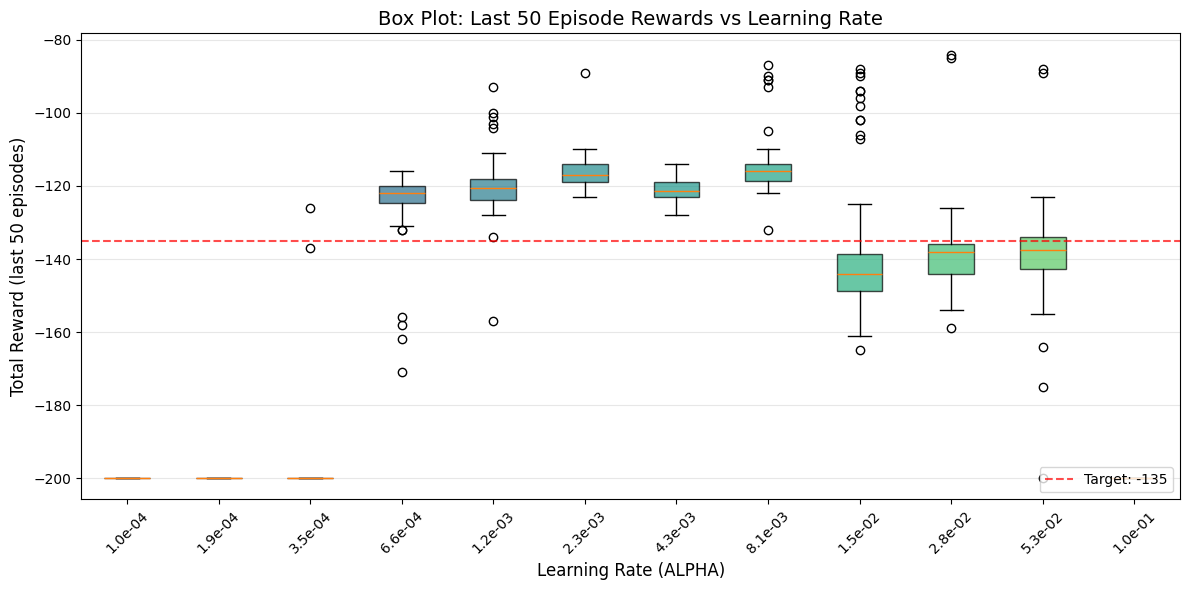

In [7]:
# Box plot of last 50 episode rewards for each ALPHA
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for box plot
box_data = [last_50_rewards[alpha] for alpha in ALPHA_values]
labels = [f'{alpha:.1e}' for alpha in ALPHA_values]

# Create box plot
bp = ax.boxplot(box_data, labels=labels, patch_artist=True)

# Color the boxes
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(ALPHA_values)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add mean and 95% CI annotation above each box
for i, alpha in enumerate(ALPHA_values):
    rewards = last_50_rewards[alpha]
    mean_val = np.mean(rewards)
    std_val = np.std(rewards)
    ci_95 = 1.96 * std_val / np.sqrt(len(rewards))
    #ax.annotate(f'μ={mean_val:.0f}\n±{ci_95:.1f}', 
    #            xy=(i+1, max(rewards)+5), ha='center', fontsize=7)

ax.axhline(-135, color='r', linestyle='--', alpha=0.7, label='Target: -135')
ax.set_xlabel('Learning Rate (ALPHA)', fontsize=12)
ax.set_ylabel('Total Reward (last 50 episodes)', fontsize=12)
ax.set_title('Box Plot: Last 50 Episode Rewards vs Learning Rate', fontsize=14)
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('alpha_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()


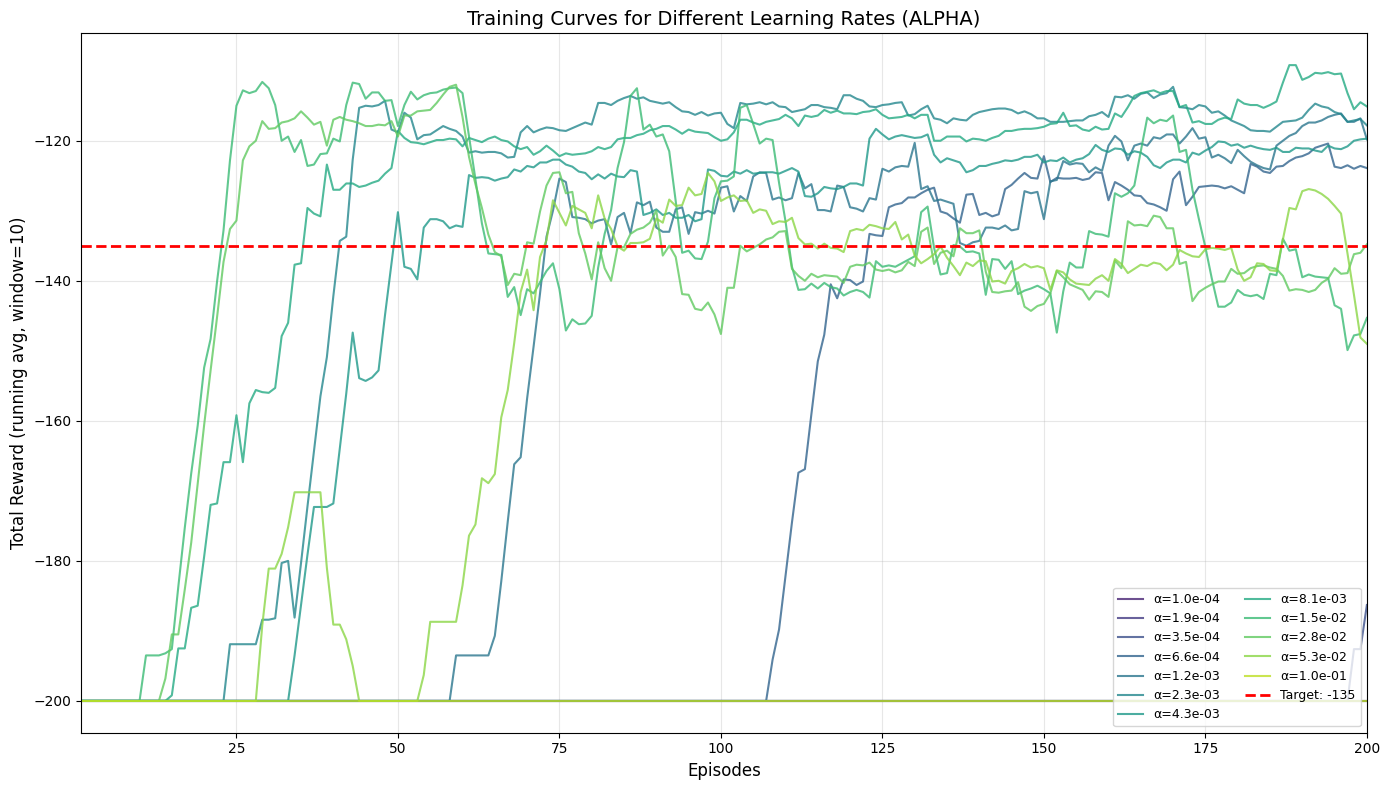

In [8]:
# Plot all training curves (episodes vs rewards) for each ALPHA
fig, ax = plt.subplots(figsize=(14, 8))
episodes = list(range(1, N_episodes + 1))

# Use colormap for different ALPHA values
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(ALPHA_values)))

for alpha_val, color in zip(ALPHA_values, colors):
    rewards = all_rewards[alpha_val]
    ax.plot(episodes, running_average(rewards, 10), color=color, 
            linewidth=1.5, label=f'α={alpha_val:.1e}', alpha=0.8)

ax.axhline(-135, color='r', linestyle='--', linewidth=2, label='Target: -135')
ax.set_xlabel('Episodes', fontsize=12)
ax.set_ylabel('Total Reward (running avg, window=10)', fontsize=12)
ax.set_title('Training Curves for Different Learning Rates (ALPHA)', fontsize=14)
ax.legend(loc='lower right', fontsize=9, ncol=2)
ax.grid(alpha=0.3)
ax.set_xlim([1, N_episodes])
plt.tight_layout()
plt.savefig('alpha_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()


In [9]:
# Train with 12 different LAMBDA values (eligibility trace), keeping ALPHA fixed at 0.003
LAMBDA_values = np.linspace(0, 1, 12)  # from 0 to 1
ALPHA_fixed = 0.003

# Store rewards for each LAMBDA
all_rewards_lambda = {}  # full training curves
last_50_rewards_lambda = {}  # last 50 episodes only
seed = np.random.randint(0, 10000)

for lam_val in LAMBDA_values:
    print(f"Training with LAMBDA = {lam_val:.3f}")
    np.random.seed(seed)
    
    model = Model(eta, lam_val, gamma, mu) 
    episode_reward_list = []

    for i in range(N_episodes):
        done = False
        truncated = False
        state = scale_state_variables(env.reset(seed=seed + i)[0])
        total_episode_reward = 0.

        eps = EPS
        alpha = ALPHA_fixed
        if i > lr_lookback and lr_threshold < np.mean(episode_reward_list[-lr_lookback:]):
            alpha *= lr_factor

        model.reset_trace()
        action = model.eps_greedy(state, eps)

        while not (done or truncated):
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = scale_state_variables(next_state)
            next_action = model.eps_greedy(next_state, eps)
            model.update_trace(state, action)
            model.update_weights_momentum(state, action, reward, next_state, next_action, alpha)
            total_episode_reward += reward
            state = next_state
            action = next_action

        episode_reward_list.append(total_episode_reward)

    all_rewards_lambda[lam_val] = episode_reward_list
    last_50_rewards_lambda[lam_val] = episode_reward_list[-50:]
    print(f"  Mean last 50: {np.mean(episode_reward_list[-50:]):.1f}")

env.close()
print("\nTraining complete!")


Training with LAMBDA = 0.000
  Mean last 50: -158.6
Training with LAMBDA = 0.091
  Mean last 50: -163.8
Training with LAMBDA = 0.182
  Mean last 50: -150.9
Training with LAMBDA = 0.273
  Mean last 50: -143.1
Training with LAMBDA = 0.364
  Mean last 50: -137.6
Training with LAMBDA = 0.455
  Mean last 50: -139.9
Training with LAMBDA = 0.545
  Mean last 50: -130.3
Training with LAMBDA = 0.636
  Mean last 50: -120.7
Training with LAMBDA = 0.727
  Mean last 50: -134.5
Training with LAMBDA = 0.818
  Mean last 50: -121.4
Training with LAMBDA = 0.909
  Mean last 50: -128.9
Training with LAMBDA = 1.000
  Mean last 50: -159.0

Training complete!


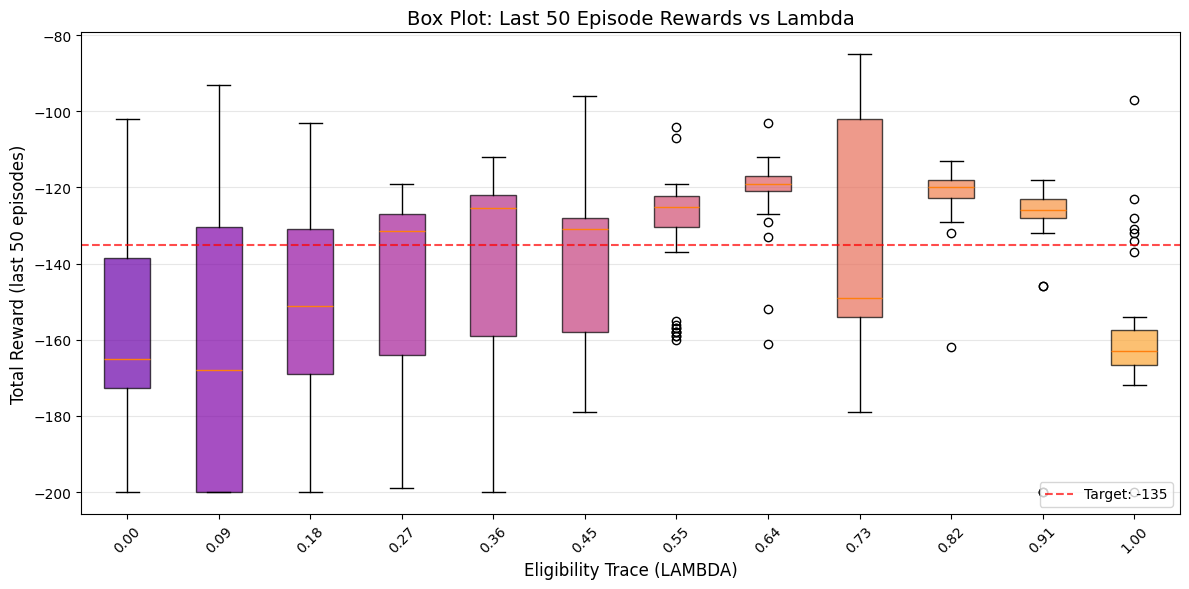

In [10]:
# Box plot of last 50 episode rewards for each LAMBDA
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for box plot
box_data = [last_50_rewards_lambda[lam] for lam in LAMBDA_values]
labels = [f'{lam:.2f}' for lam in LAMBDA_values]

# Create box plot
bp = ax.boxplot(box_data, tick_labels=labels, patch_artist=True)

# Color the boxes with a different colormap (plasma)
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(LAMBDA_values)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(-135, color='r', linestyle='--', alpha=0.7, label='Target: -135')
ax.set_xlabel('Eligibility Trace (LAMBDA)', fontsize=12)
ax.set_ylabel('Total Reward (last 50 episodes)', fontsize=12)
ax.set_title(f'Box Plot: Last 50 Episode Rewards vs Lambda', fontsize=14)
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('lambda_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()


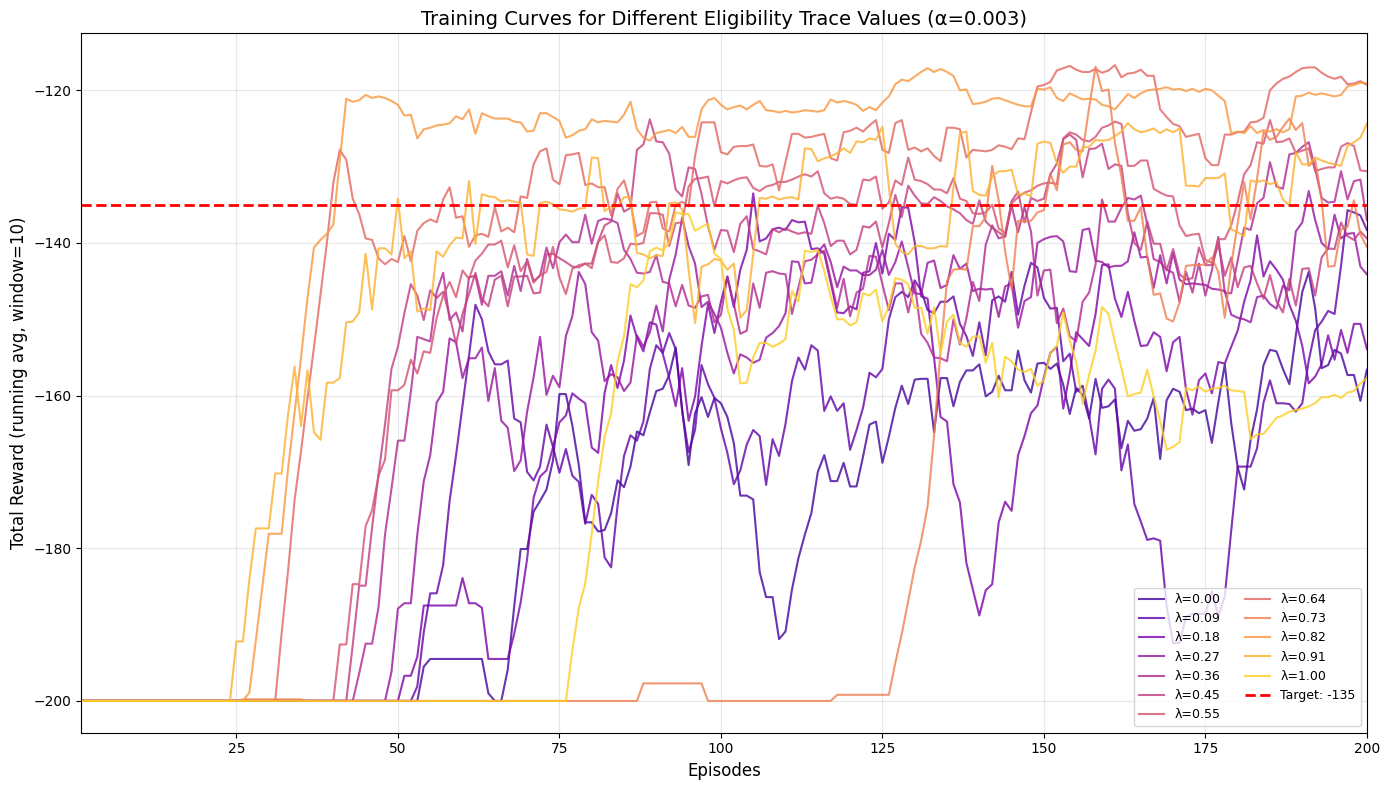

In [11]:
# Plot all training curves (episodes vs rewards) for each LAMBDA
fig, ax = plt.subplots(figsize=(14, 8))
episodes = list(range(1, N_episodes + 1))

# Use plasma colormap for different LAMBDA values
colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(LAMBDA_values)))

for lam_val, color in zip(LAMBDA_values, colors):
    rewards = all_rewards_lambda[lam_val]
    ax.plot(episodes, running_average(rewards, 10), color=color, 
            linewidth=1.5, label=f'λ={lam_val:.2f}', alpha=0.8)

ax.axhline(-135, color='r', linestyle='--', linewidth=2, label='Target: -135')
ax.set_xlabel('Episodes', fontsize=12)
ax.set_ylabel('Total Reward (running avg, window=10)', fontsize=12)
ax.set_title(f'Training Curves for Different Eligibility Trace Values (α={ALPHA_fixed})', fontsize=14)
ax.legend(loc='lower right', fontsize=9, ncol=2)
ax.grid(alpha=0.3)
ax.set_xlim([1, N_episodes])
plt.tight_layout()
plt.savefig('lambda_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()


In [32]:
# Run 15 training runs with different random seeds
seeds = np.random.randint(0, 10000, size=15).tolist()
all_episode_rewards = []

for seed in seeds:
    np.random.seed(seed)
    
    model = Model(eta, lam, gamma, mu, weight_init="zeros") 
    episode_reward_list = []

    # Training process
    for i in range(N_episodes):
        # Reset enviroment data
        done = False
        truncated = False
        state = scale_state_variables(env.reset(seed=seed + i)[0])
        total_episode_reward = 0.

        eps = EPS

        alpha = ALPHA
        if i > lr_lookback and lr_threshold < np.mean(episode_reward_list[-lr_lookback:]):
            alpha *= lr_factor

        model.reset_trace()
        action = model.eps_greedy(state, eps)

        while not (done or truncated):
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = scale_state_variables(next_state)

            next_action = model.eps_greedy(next_state, eps)

            model.update_trace(state, action)
            model.update_weights_momentum(state, action, reward, next_state, next_action, alpha)
            
            # Update episode reward
            total_episode_reward += reward
            
            # Update state for next iteration
            state = next_state
            action = next_action

        # Append episode reward
        episode_reward_list.append(total_episode_reward)

    all_episode_rewards.append(episode_reward_list)
    print(f"Seed {seed} done, final avg reward: {np.mean(episode_reward_list[-10:]):.1f}")

env.close()
    

Seed 5858 done, final avg reward: -124.3
Seed 3915 done, final avg reward: -146.5
Seed 2647 done, final avg reward: -127.4
Seed 830 done, final avg reward: -118.0
Seed 4828 done, final avg reward: -125.9
Seed 6690 done, final avg reward: -121.7
Seed 8697 done, final avg reward: -121.7
Seed 2857 done, final avg reward: -118.2
Seed 9764 done, final avg reward: -119.8
Seed 2523 done, final avg reward: -124.2
Seed 8835 done, final avg reward: -121.0
Seed 5091 done, final avg reward: -122.9
Seed 6011 done, final avg reward: -127.4
Seed 3192 done, final avg reward: -123.1
Seed 3897 done, final avg reward: -125.1


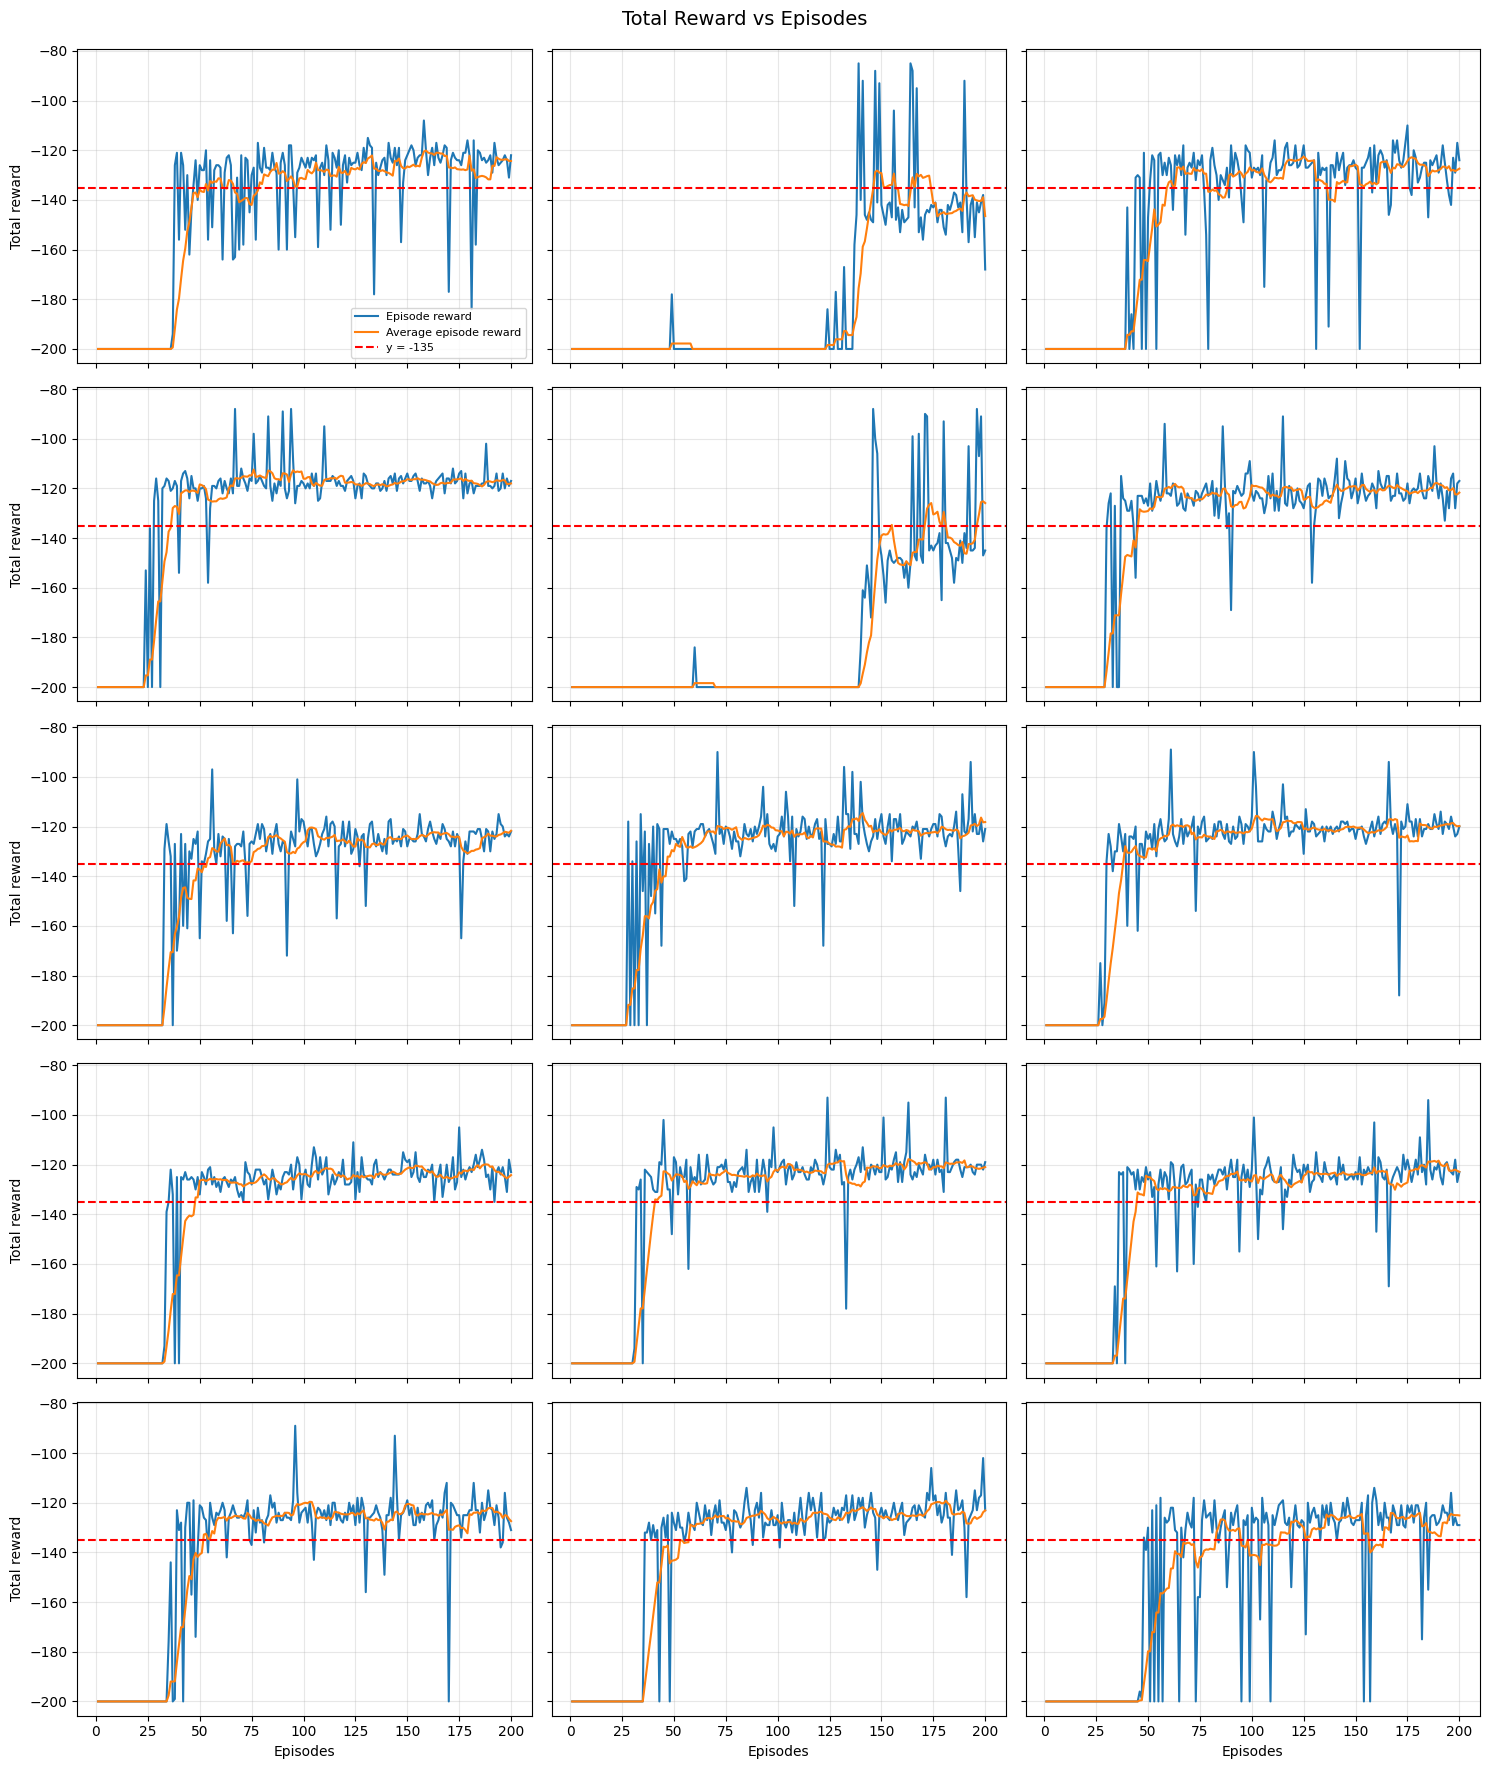

In [33]:
# Plot Rewards for all 15 runs in a 5x3 grid
fig, axes = plt.subplots(5, 3, figsize=(15, 18), sharex=True, sharey=True)
episodes = list(range(1, N_episodes + 1))

for idx, (ax, rewards) in enumerate(zip(axes.ravel(), all_episode_rewards)):
    ax.plot(episodes, rewards, label='Episode reward')
    ax.plot(episodes, running_average(rewards, 10), label='Average episode reward')
    ax.axhline(-135, color='r', linestyle='--', label='y = -135')
    ax.set_title(f'')
    ax.grid(alpha=0.3)
    if idx == 0:
        ax.legend(loc='lower right', fontsize=8)

for ax in axes[-1]:
    ax.set_xlabel('Episodes')
for ax in axes[:, 0]:
    ax.set_ylabel('Total reward')

fig.suptitle('Total Reward vs Episodes\n', fontsize=14)
fig.tight_layout()
plt.show()

In [29]:
# Run 15 training runs with different random seeds
seeds = np.random.randint(0, 10000, size=15).tolist()
all_episode_rewards = []

for seed in seeds:
    np.random.seed(seed)
    
    model = Model(eta, lam, gamma, mu, weight_init="gaussian") 
    episode_reward_list = []

    # Training process
    for i in range(N_episodes):
        # Reset enviroment data
        done = False
        truncated = False
        state = scale_state_variables(env.reset(seed=seed + i)[0])
        total_episode_reward = 0.

        eps = EPS

        alpha = ALPHA
        if i > lr_lookback and lr_threshold < np.mean(episode_reward_list[-lr_lookback:]):
            alpha *= lr_factor

        model.reset_trace()
        action = model.eps_greedy(state, eps)

        while not (done or truncated):
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = scale_state_variables(next_state)

            next_action = model.eps_greedy(next_state, eps)

            model.update_trace(state, action)
            model.update_weights_momentum(state, action, reward, next_state, next_action, alpha)
            
            # Update episode reward
            total_episode_reward += reward
            
            # Update state for next iteration
            state = next_state
            action = next_action

        # Append episode reward
        episode_reward_list.append(total_episode_reward)

    all_episode_rewards.append(episode_reward_list)
    print(f"Seed {seed} done, final avg reward: {np.mean(episode_reward_list[-10:]):.1f}")

env.close()
    

Seed 4472 done, final avg reward: -192.3
Seed 787 done, final avg reward: -154.8
Seed 4400 done, final avg reward: -122.7
Seed 1736 done, final avg reward: -124.1
Seed 1583 done, final avg reward: -119.9
Seed 2131 done, final avg reward: -130.9
Seed 4031 done, final avg reward: -187.9
Seed 2025 done, final avg reward: -118.3
Seed 6465 done, final avg reward: -142.7
Seed 2044 done, final avg reward: -121.3
Seed 3139 done, final avg reward: -117.9
Seed 7162 done, final avg reward: -120.9
Seed 703 done, final avg reward: -121.1
Seed 5423 done, final avg reward: -134.9
Seed 5139 done, final avg reward: -116.1


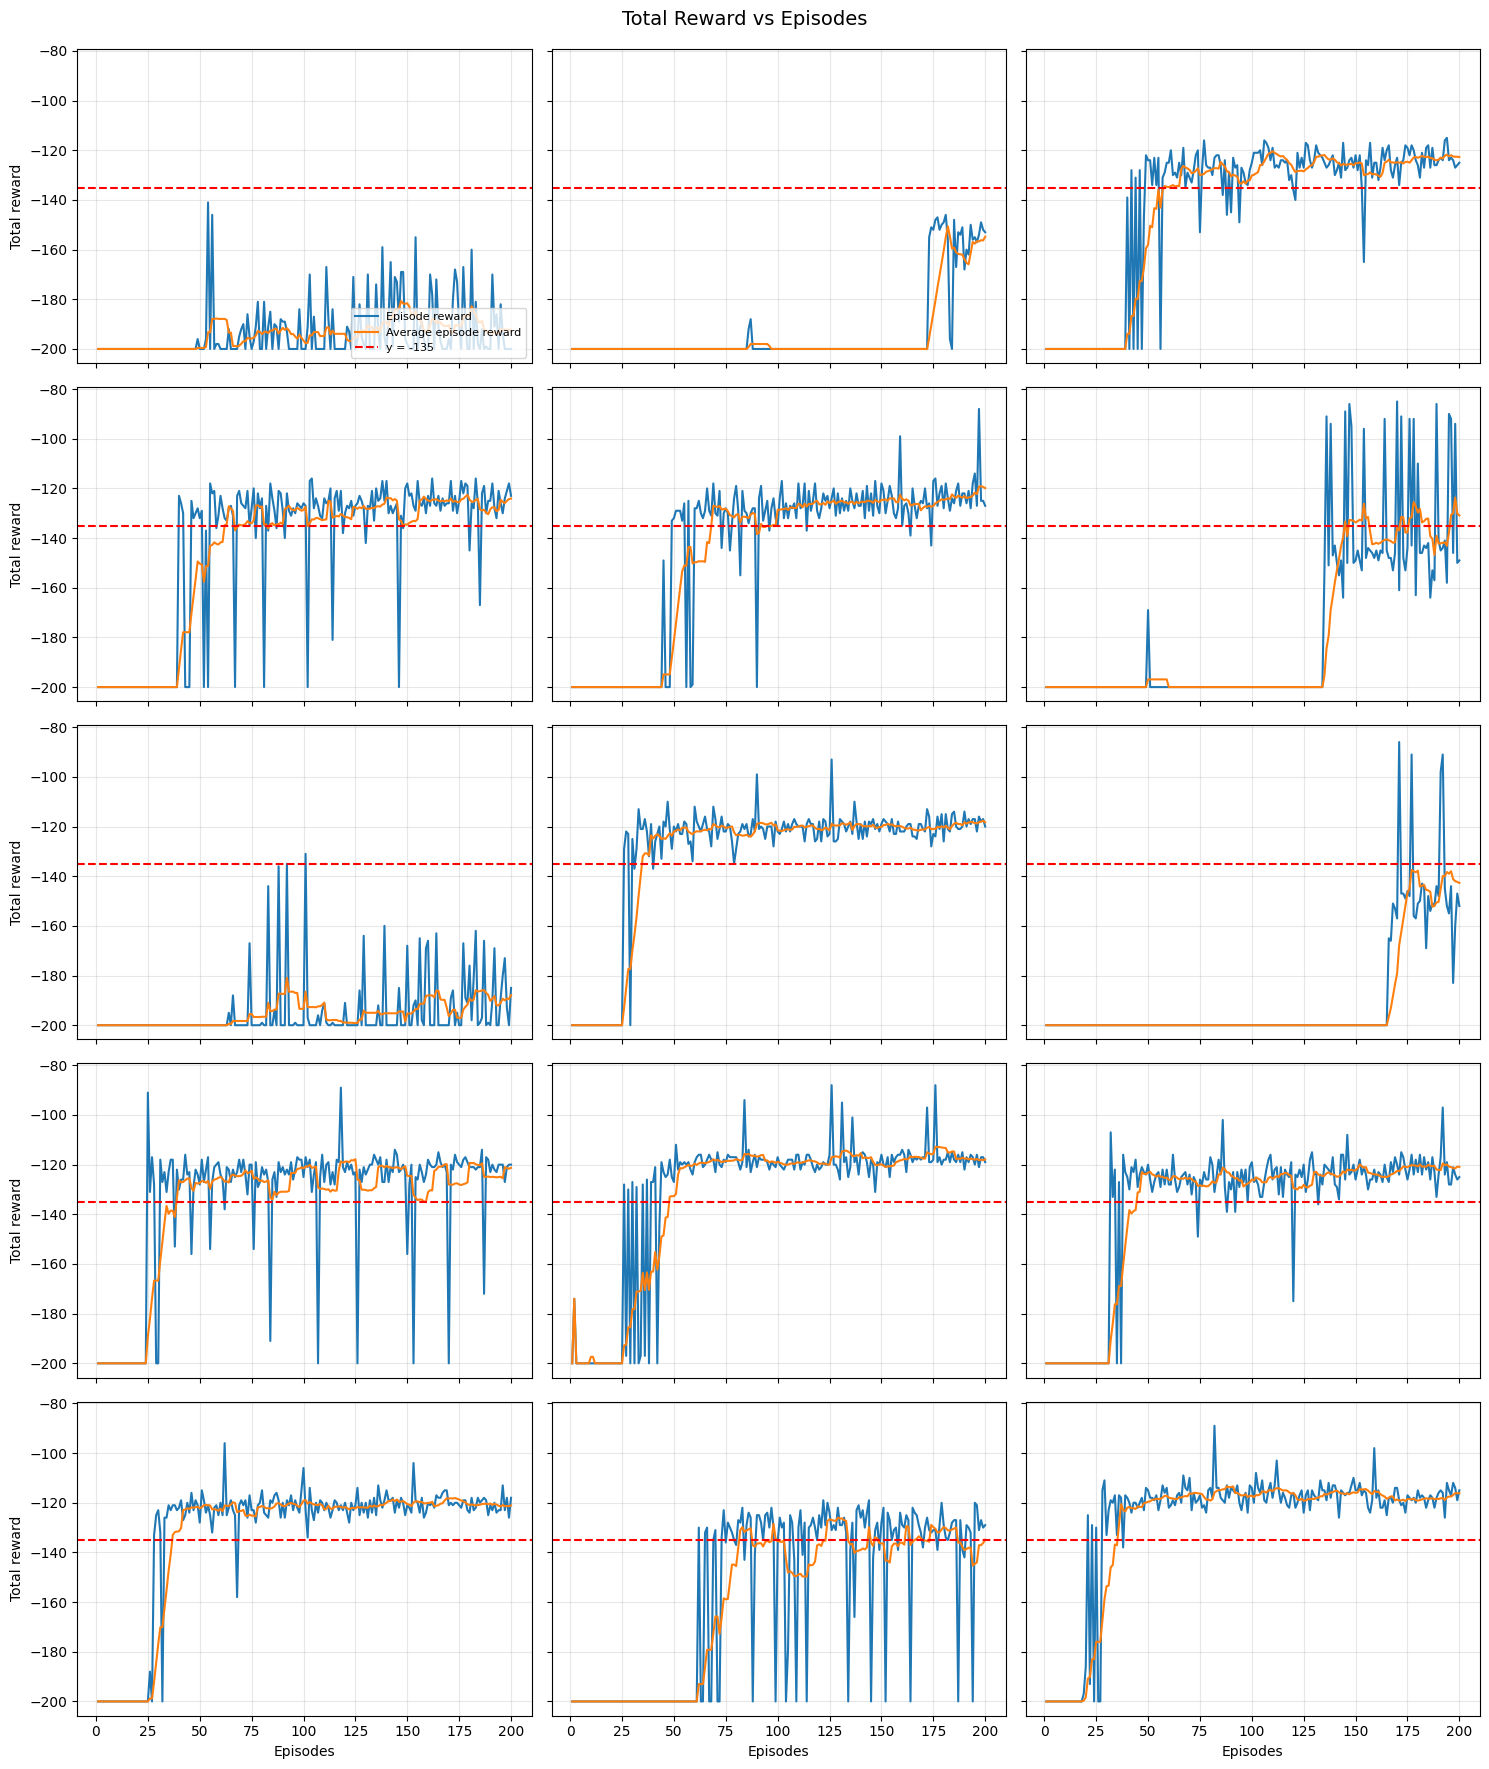

In [30]:
# Plot Rewards for all 15 runs in a 5x3 grid
fig, axes = plt.subplots(5, 3, figsize=(15, 18), sharex=True, sharey=True)
episodes = list(range(1, N_episodes + 1))

for idx, (ax, rewards) in enumerate(zip(axes.ravel(), all_episode_rewards)):
    ax.plot(episodes, rewards, label='Episode reward')
    ax.plot(episodes, running_average(rewards, 10), label='Average episode reward')
    ax.axhline(-135, color='r', linestyle='--', label='y = -135')
    ax.set_title(f'')
    ax.grid(alpha=0.3)
    if idx == 0:
        ax.legend(loc='lower right', fontsize=8)

for ax in axes[-1]:
    ax.set_xlabel('Episodes')
for ax in axes[:, 0]:
    ax.set_ylabel('Total reward')

fig.suptitle('Total Reward vs Episodes\n', fontsize=14)
fig.tight_layout()
plt.show()